In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kruskal

In [5]:
df_eco = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Annotation/ecocyc.gaf", header=None, sep="\t")
def table_to_go(input_file):
    df2 = pd.read_csv(input_file, sep="\t")
    df2 = df2[df2['locus_tag']!='locus_tag']
    set_genes = set(df2['gene'])
    set_genes = {x for x in set_genes if x==x}
    df_test = df_eco[df_eco[2].isin(set_genes)]
    counts = df_test.groupby(4).count()
    counts = counts[[0]]
    return(counts, set_genes)

### CF Metagenomes Versus Controls

In [10]:
df = pd.read_excel("../data/Viral_Contigs_in_CF_Metagenome/Read_Statistics/CF_Metagenome_project_stats.xlsx")
x = df[df['Condition']=="CF"]
y = df[df['Condition']=="Control"]
print("Mean Percentage of Human Reads in CF Samples: "+str(round(x['Human_Read_Pecentage'].mean(), 2)))+"%"
print("Mean Percentage of Human Reads in Controls Samples: "+str(round(y['Human_Read_Pecentage'].mean(), 2)))+"%"
kruskal(x['Human_Read_Pecentage'], y['Human_Read_Pecentage'])


Mean Percentage of Human Reads in CF Samples: 28.09%
Mean Percentage of Human Reads in Controls Samples: 16.37%


KruskalResult(statistic=5.338235294117652, pvalue=0.020862582332765417)

In [12]:
print("Percentage of Viral Contigs in classified contigs of CF samples: "+str(round(x['Viral_Percentage_Classified'].mean(), 2)))+"%"
print("Percentage of Viral Contigs in classified contigs of Controls: "+str(round(y['Viral_Percentage_Classified'].mean(), 2)))+"%"
kruskal(x['Viral_Percentage_Classified'], y['Viral_Percentage_Classified'])

Percentage of Viral Contigs in classified contigs of CF samples: 0.35%
Percentage of Viral Contigs in classified contigs of Controls: 0.17%


KruskalResult(statistic=1.588235294117652, pvalue=0.2075784423356198)

In [13]:
print("Percentage of Viral Contigs in CF samples: "+str(round(x['Viral_Percentage_Whole'].mean(), 2)))+"%"
print("Percentage of Viral Contigs in Controls: "+str(round(y['Viral_Percentage_Whole'].mean(), 2)))+"%"
kruskal(x['Viral_Percentage_Whole'], y['Viral_Percentage_Whole'])

Percentage of Viral Contigs in CF samples: 0.29%
Percentage of Viral Contigs in Controls: 0.11%


KruskalResult(statistic=1.863970588235297, pvalue=0.17216723606659268)

### Gene Ontology List Creation

In [19]:
with open("../data/Viral_Contigs_in_CF_Metagenome/Annotation/go-basic.obo", "r") as f:
    q = f.read()
    
q = q.split("[Term]")
q.pop(0)

my_dict = {}
for ids in q:
    go_id = ids.split(" ")[1].split("\n")[0]
    try:
        name = ids.split("name:")[1].lstrip().split("\n")[0]
    except:
        name = "NaN"
    try:
        level = ids.split("is_a:")[-1].split("!")[1].lstrip().split("\n")[0]
    except:
        level = "NaN"
    try:
        namespace = ids.split("namespace:")[1].lstrip().split("\n")[0]
    except:
        namespace = "NaN"
    
    my_dict[go_id] = [name, namespace, level]
    
df_dict = pd.DataFrame.from_dict(my_dict)
df_dict = pd.DataFrame(df_dict.transpose())
df_dict.columns = ["Name", 'Ontology', "Sublevel"]

In [23]:
cf_genes, cfg = table_to_go("../data/Viral_Contigs_in_CF_Metagenome/Prokka_Output/CF_Genes.tsv")
control_genes, cg = table_to_go("../data/Viral_Contigs_in_CF_Metagenome/Prokka_Output/Control_Genes.tsv") 

cf_genes = df_dict.merge(cf_genes, right_index=True, left_index=True)
control_genes = df_dict.merge(control_genes, right_index=True, left_index=True)

print("Number of ontology terms in CF Samples: " + str(len(cf_genes)))
print("Number of ontology terms in Control Samples: " + str(len(control_genes)))

control_genes.to_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/control_genes_ontology.csv")
cf_genes.to_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/cf_genes_ontology.csv")

Number of ontology terms in CF Samples: 28
Number of ontology terms in Control Samples: 151


### Perform Gene Ontology Traversal in R

### Visualize Gene Ontology Percentages

In [24]:
def plot_1d_heatmap(df, vmin=0, vmax=100):
    q3 = df.sort_index()
    q3['percentage'] = (q3['Count']/q3['Count'].sum())*100
    labels = list(q3.index)
    vals = []
    vals.append(list(q3["percentage"]))
    values = np.array(vals)


    fig, ax = plt.subplots()
    im = ax.pcolor(np.arange(len(labels)+1) - .5, [0, 1], values, cmap='Purples', vmin=vmin, vmax=vmax, edgecolors='grey', linewidths=1)
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

    ax.set_xticklabels(labels)
    ax.set_xticks( np.arange(len(labels)) )  # Show all data

    ax.set_yticks([])  # No Y axis
    ax.xaxis.tick_top()  # Put labels on top
    plt.xticks(rotation=45, ha="left", rotation_mode="anchor")  # Rotate labels 45 deg
    plt.axis('scaled')  # square pixels
    ax.tick_params(axis='both', which='both', length=0)  # Hide ticks

    fig.tight_layout()
    plt.show()
    return(q3)

#### Molecular Function and Cellular Component

##### Control Samples

Number of Control CC|MF Ontology Terms: 252


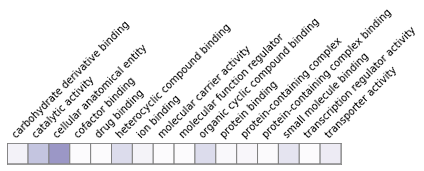

<Figure size 432x288 with 0 Axes>

In [33]:
## Combine MF and CC
control_cc = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/control_ontology_R_cc.csv")
control_cc['X[[i]]'] = control_cc['X[[i]]'].str.replace(r'(^.*nucleoid.*$)', 'cellular anatomical entity')
control_cc['X[[i]]'] = control_cc['X[[i]]'].str.replace(r'(^.*intracellular.*$)', 'cellular anatomical entity')
control_cc['X[[i]]'] = control_cc['X[[i]]'].str.replace(r'(^.*cell periphery.*$)', 'cellular anatomical entity')
control_cc['X[[i]]'] = control_cc['X[[i]]'].str.replace(r'(^.*membrane.*$)', 'cellular anatomical entity')
control_cc['X[[i]]'] = control_cc['X[[i]]'].str.replace(r'(^.*organelle.*$)', 'cellular anatomical entity')
control_cc['Count'] = 1
set(control_cc['X[[i]]'])

control_mf = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/control_ontology_R_mf.csv")
control_mf['Count'] = 1
set(control_mf['X[[i]]'])

control_cc_mf = pd.concat([control_mf, control_cc])

cccmf = set(control_cc_mf['X[[i]]'])
print("Number of Control CC|MF Ontology Terms: " + str(len(control_cc_mf)))
control_merged = control_cc_mf.groupby('X[[i]]').count()
control_merged = plot_1d_heatmap(control_merged, vmax=51)
control_merged = control_merged.reset_index()
plt.savefig("../figures/Figure_5_Gene_Ontology/Ontology_Percentage_Control_CC_MF.jpg")

##### CF Samples

Number of CF CC|MF Ontology Terms: 20


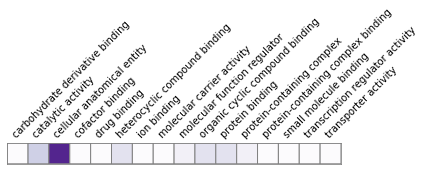

<Figure size 432x288 with 0 Axes>

In [34]:
## Combine MF and CC
cf_cc = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/cf_ontology_R_cc.csv")
cf_cc['X[[i]]'] = cf_cc['X[[i]]'].str.replace(r'(^.*nucleoid.*$)', 'cellular anatomical entity')
cf_cc['X[[i]]'] = cf_cc['X[[i]]'].str.replace(r'(^.*intracellular.*$)', 'cellular anatomical entity')
cf_cc['Count'] = 1
set(cf_cc['X[[i]]'])

cf_mf = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/cf_ontology_R_mf.csv")

set(cf_mf['X[[i]]'])
cf_mf['Count'] = 1
cf_cc_mf = pd.concat([cf_mf, cf_cc])

cfccmf = set(cf_cc_mf['X[[i]]'])

diff = list(cccmf-cfccmf)
diff_dict = {}
for item in diff:
    diff_dict[item] = 0

## Add missing ontology terms to CF samples    
data = cf_cc_mf.groupby('X[[i]]').count()
diff_df = pd.DataFrame.from_dict(diff_dict, orient='index')
diff_df.columns = ["Count"]
cf_merged = pd.concat([data, diff_df])

## Plot 1d
print("Number of CF CC|MF Ontology Terms: " + str(len(cf_cc_mf)))
cf_merged = plot_1d_heatmap(cf_merged, vmax=51)
cf_merged = cf_merged.reset_index()
plt.savefig("../figures/Figure_5_Gene_Ontology/Ontology_Percentage_CF_CC_MF.jpg")

In [30]:
cf_merged['Difference'] = np.where(cf_merged['index'] == control_merged['X[[i]]'], cf_merged['percentage'] - control_merged['percentage'], 0)
differences = cf_merged[['index', "Difference"]]
## + means higher percentage in CF, - means higher percentage in controls
differences

,index,Difference
0,carbohydrate derivative binding,-4.365079
1,catalytic activity,-2.460317
2,cellular anatomical entity,18.809524
3,cofactor binding,-0.396825
4,drug binding,-0.396825
5,heterocyclic compound binding,-2.301587
6,ion binding,-3.968254
7,molecular carrier activity,-0.396825
8,molecular function regulator,4.603175
9,organic cyclic compound binding,-2.301587


#### Biological Process

##### Control Samples

Number of Control BP Ontology Terms: 6609


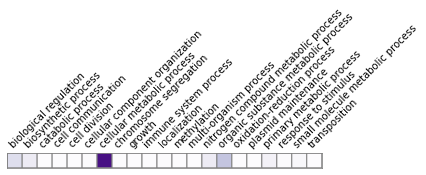

<Figure size 432x288 with 0 Axes>

In [37]:
control_bp = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/control_ontology_R_bp.csv")
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular nitrogen compound metabolic process.*$)', 'nitrogen compound metabolic process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular response to stimulus.*$)', 'response to stimulus')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular macromolecule metabolic process.*$)', 'macromolecule metabolic process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular biosynthetic process.*$)', 'biosynthetic process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*regulation of.*$)', 'biological regulation')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular carbohydrate metabolic process.*$)', 'primary metabolic process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular catabolic process.*$)', 'catabolic process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cellular component organization or biogenesis.*$)', 'cellular component organization')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*multi-organism cellular process.*$)', 'multi-organism process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*organic acid metabolic process.*$)', 'organic substance metabolic process')
control_bp['X[[i]]'] = control_bp['X[[i]]'].str.replace(r'(^.*cell growth.*$)', 'growth')

control_bp["Count"] = 1
control_bp = control_bp[control_bp['X[[i]]']!="metabolic process"]
cbp = set(control_bp['X[[i]]'])

print("Number of Control BP Ontology Terms: " + str(len(control_bp)))
control_merged = control_bp.groupby('X[[i]]').count()
control_merged = plot_1d_heatmap(control_merged, vmax=51)
control_merged = control_merged.reset_index()
plt.savefig("../figures/Figure_5_Gene_Ontology/Ontology_Percentage_Control_BP.jpg")

##### CF Samples

Number of CF BP Ontology Terms: 183


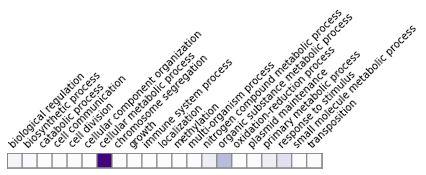

<Figure size 432x288 with 0 Axes>

In [38]:
cf_bp = pd.read_csv("../data/Viral_Contigs_in_CF_Metagenome/Gene_Ontology/cf_ontology_R_bp.csv")
cf_bp['X[[i]]'] = cf_bp['X[[i]]'].str.replace(r'(^.*cellular nitrogen compound metabolic process.*$)', 'nitrogen compound metabolic process')
cf_bp['X[[i]]'] = cf_bp['X[[i]]'].str.replace(r'(^.*cellular response to stimulus.*$)', 'response to stimulus')
cf_bp['X[[i]]'] = cf_bp['X[[i]]'].str.replace(r'(^.*cellular macromolecule metabolic process.*$)', 'macromolecule metabolic process')
cf_bp['X[[i]]'] = cf_bp['X[[i]]'].str.replace(r'(^.*cellular biosynthetic process.*$)', 'biosynthetic process')
cf_bp["Count"] = 1
cfbp = set(cf_bp['X[[i]]'])

diff = list(cbp-cfbp)
diff_dict = {}
for item in diff:
    diff_dict[item] = 0
    
data = cf_bp.groupby('X[[i]]').count()
diff_df = pd.DataFrame.from_dict(diff_dict, orient='index')
diff_df.columns = ["Count"]

print("Number of CF BP Ontology Terms: " + str(len(cf_bp)))
cf_merged = pd.concat([data, diff_df])
cf_merged = plot_1d_heatmap(cf_merged, vmax=51)
cf_merged = cf_merged.reset_index()
plt.savefig("../figures/Figure_5_Gene_Ontology/Ontology_Percentage_CF_BP.jpg")

In [39]:
cf_merged['Difference'] = np.where(cf_merged['index'] == control_merged['X[[i]]'], cf_merged['percentage'] - control_merged['percentage'], 0)
differences = cf_merged[['index', "Difference"]]
## + means higher percentage in CF, - means higher percentage in controls
differences

,index,Difference
0,biological regulation,-8.266175
1,biosynthetic process,-6.003488
2,catabolic process,-0.242094
3,cell communication,0.531317
4,cell division,0.531317
5,cellular component organization,-0.453926
6,cellular metabolic process,2.005710
7,chromosome segregation,0.531317
8,growth,-0.105916
9,immune system process,-0.015131
